In [1]:
%run imports.ipynb

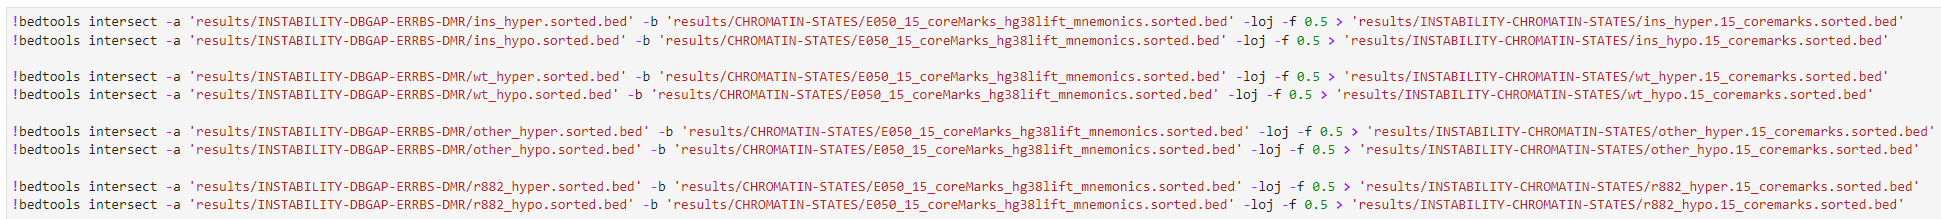

In [15]:
for context in ['ins', 'wt', 'other', 'r882']:
    !cp ../note2/results/INSTABILITY-CHROMATIN-STATES/{context}_hyper.15_coremarks.sorted.bed source_data/{context}_vs_nbm_hyper.chromhmm_15_coremarks.sorted.bed
    !cp ../note2/results/INSTABILITY-CHROMATIN-STATES/{context}_hypo.15_coremarks.sorted.bed source_data/{context}_vs_nbm_hypo.chromhmm_15_coremarks.sorted.bed

### Li2016 RRBS가 cover하는 지역

CpG들 양쪽으로 100bp slop하고 merge 후, ChromHMM state와 intersection (loj, f=0.5) 을 구하여 각 지역을 annotate.

In [7]:
rrbs_background = pd.read_csv('../note2/results/CHROMATIN-STATES/dbgap_rrbs.background_coreMarks.sorted.bed', sep='\t', names=['chrom', 'start', 'end', 'state_chrom', 'state_start', 'state_end', 'type'])

In [12]:
rrbs_background.to_csv('source_data/li2016_covered_region_background_chromhmm_contexts.csv', index=False)
rrbs_background = pd.read_csv('source_data/li2016_covered_region_background_chromhmm_contexts.csv')

In [13]:
core_marks = pd.read_csv('../note2/results/CHROMATIN-STATES/E050_15_coreMarks_hg38lift_mnemonics.sorted.bed', sep='\t', names=['chrom', 'start', 'end', 'type'])

In [14]:
background_genome_size = (rrbs_background.end - rrbs_background.start).sum()

rrbs_background_normalized_lengths = dict()

for state in core_marks.type.unique():
    rrbs_background_normalized_lengths[state] = (rrbs_background[rrbs_background.type == state].end - rrbs_background[rrbs_background.type == state].start).sum() / background_genome_size

In [33]:
names = ['chrom', 'start', 'end', 'name', 'state_chrom', 'state_start', 'state_end', 'state_type']

data = []
for subclass in ['ins', 'r882', 'other', 'wt']:
    for dmr_type in ['hyper', 'hypo']:
        tmp = pd.read_csv(f'source_data/{subclass}_vs_nbm_{dmr_type}.chromhmm_15_coremarks.sorted.bed', sep='\t', names=names)
        tmp['length'] = tmp.end - tmp.start
        tmp['normalized_length'] = tmp.length / tmp.length.sum()

        tmp = tmp.groupby('state_type').agg({'length': 'sum', 'normalized_length': 'sum'}).reset_index()
        tmp['subclass'] = subclass
        tmp['vs_NBM_dmr_type'] = dmr_type

        data.append(tmp)

data = pd.concat(data)
data = data[data.state_type != '.']

data['null_normalized_length'] = data.state_type.map(rrbs_background_normalized_lengths)
data['enrichment'] = data['normalized_length'] / data['null_normalized_length']
data['log_enrichment'] = np.log10(data['enrichment'])

In [35]:
data.to_csv('source_data/dmr_chromhmm_context_enrichment.csv', index=False)

In [21]:
mnemonics_mapping = {
    '1_TssA': 'Active TSS',
    '2_TssAFlnk': 'Flanking active TSS',
    '3_TxFlnk': 'Transcription at gene 5\' and 3\'',
    '4_Tx': 'Strong transcription',
    '5_TxWk': 'Weak transcription',
    '6_EnhG': 'Genic enhancers',
    '7_Enh': 'Enhancers',
    '8_ZNF/Rpts': 'ZNF genes & repeats',
    '9_Het': 'Heterochromatin',
    '10_TssBiv': 'Bivalent/Poised TSS',
    '11_BivFlnk': 'Flanking bivalent TSS/Enhancer',
    '12_EnhBiv': 'Bivalent enhancer',
    '13_ReprPC': 'Repressed polycomb',
    '14_ReprPCWk': 'Weak repressed polycomb',
    '15_Quies': 'Quiescent/Low',
}

state_types = list(mnemonics_mapping.keys())

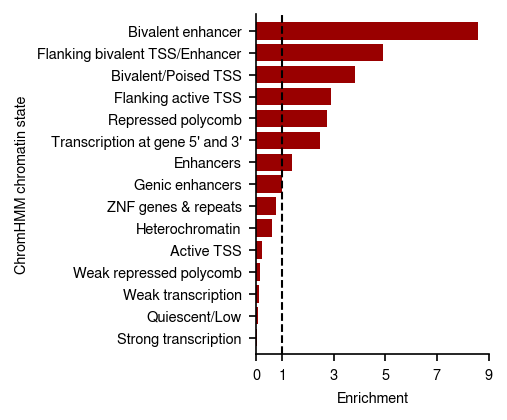

In [36]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

fig = plt.figure(figsize=(2, 3))
ax = fig.add_subplot(111)

d = data[(data.subclass == 'ins') & (data.vs_NBM_dmr_type == 'hyper')].sort_values('enrichment', ascending=False)
sns.barplot(data=d, x='enrichment', y='state_type', orient='h', fc='#990000', lw=0, ax=ax)

ax.axvline(1.0, ls='--', lw=1, c='k')

ax.set_xticks([0.0, 1.0, 3, 5, 7, 9])
ax.set_yticklabels([mnemonics_mapping[m.get_text()] for m in ax.get_yticklabels()], fontsize=7)

ax.set_ylim([14.75, -0.75])

for d in ['top', 'right']:
    ax.spines[d].set_visible(False)

ax.set_xlabel('Enrichment')
ax.set_ylabel('ChromHMM chromatin state')

save_figures('source_data_figures/chromhmm_enrichment_analysis/ins_vs_nbm_hyper_enrichment')